<a href="https://colab.research.google.com/github/duc-ke/DNN_CV_complete_guide/blob/main/st04/mm_faster_rcnn_train_coco_bccd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MMDetection 설치
* 강의 영상에는 pip install mmcv-full로 mmcv를 설치(약 10분 정도의 시간이 소요)
* 실습코드는 pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html 로 변경(설치에 12초 정도 걸림). 

In [1]:
import torch
torch.__version__

'1.11.0+cu113'

In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html
     |████████████████████████████████| 37.5 MB 111 kB/s 
     |████████████████████████████████| 190 kB 5.3 MB/s 
Cloning into 'mmdetection'...
remote: Enumerating objects: 24423, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 24423 (delta 18), reused 18 (delta 1), pack-reused 24364
Receiving objects: 100% (24423/24423), 37.56 MiB | 25.87 MiB/s, done.
Resolving deltas: 100% (17074/17074), done.
running install
running bdist_egg
running egg_info
creating mmdet.egg-info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
writing manifest file 'mmdet.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'mmdet.egg-info/SOURCES

In [1]:
# 아래를 수행하기 전에 kernel을 restart 해야 함. 
from mmdet.apis import init_detector, inference_detector
import mmcv

### PASCAL VOC형태의 BCCD Dataset를 Download 후 MS-COCO 형태로 변경
* BCCD Dataset은 백혈구(WBC), 적혈구(RBC), 혈소판(Platelets) 세가지 유형의 Object Class를 가짐.
* 다운로드 받은 Dataset은 Pascal VOC 형태이므로 이를 별도의 유틸리티를 이용하여 MS-COCO 형태로 변환 


In [2]:
!git clone https://github.com/Shenggan/BCCD_Dataset.git

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800
Receiving objects: 100% (800/800), 7.39 MiB | 20.61 MiB/s, done.
Resolving deltas: 100% (378/378), done.


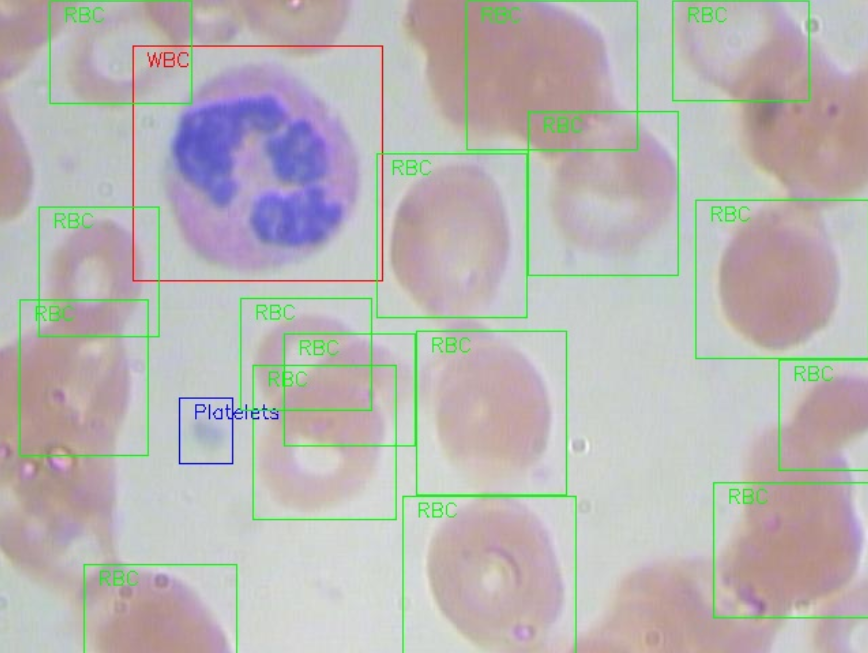

### VOC를 COCO로 변환하는 package적용하기
* https://github.com/yukkyo/voc2coco.git 들어가보면 label.txt 만드는 방법 나와있음.
* 나머지는 BBCD에 있는 파일 그대로 쓸수 있다.

In [3]:
!git clone https://github.com/yukkyo/voc2coco.git

Cloning into 'voc2coco'...
remote: Enumerating objects: 423, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 423 (delta 3), reused 10 (delta 2), pack-reused 409
Receiving objects: 100% (423/423), 214.47 KiB | 2.08 MiB/s, done.
Resolving deltas: 100% (379/379), done.


In [4]:
# 이렇게 lables.txt를 만들어야 voc2coco를 쓸수 있다.
import os

# colab 버전은 아래 명령어로 ballnfish_classes.txt 를 수정합니다. 
with open('/content/BCCD_Dataset/BCCD/labels.txt', "w") as f:
    f.write("WBC\n")
    f.write("RBC\n")
    f.write("Platelets\n")

!cat /content/BCCD_Dataset/BCCD/labels.txt

WBC
RBC
Platelets


### meta 파일 생성 (json)

In [5]:
# VOC를 COCO로 변환 수행. 학습/검증/테스트 용 json annotation을 생성. 
%cd voc2coco
!python voc2coco.py --ann_dir /content/BCCD_Dataset/BCCD/Annotations \
--ann_ids /content/BCCD_Dataset/BCCD/ImageSets/Main/train.txt \
--labels /content/BCCD_Dataset/BCCD/labels.txt \
--output /content/BCCD_Dataset/BCCD/train.json \
--ext xml

!python voc2coco.py --ann_dir /content/BCCD_Dataset/BCCD/Annotations \
--ann_ids /content/BCCD_Dataset/BCCD/ImageSets/Main/val.txt \
--labels /content/BCCD_Dataset/BCCD/labels.txt \
--output /content/BCCD_Dataset/BCCD/val.json \
--ext xml

!python voc2coco.py --ann_dir /content/BCCD_Dataset/BCCD/Annotations \
--ann_ids /content/BCCD_Dataset/BCCD/ImageSets/Main/test.txt \
--labels /content/BCCD_Dataset/BCCD/labels.txt \
--output /content/BCCD_Dataset/BCCD/test.json \
--ext xml

/content/voc2coco
Start converting !
100% 205/205 [00:00<00:00, 3385.26it/s]
Start converting !
100% 87/87 [00:00<00:00, 2774.88it/s]
Start converting !
100% 72/72 [00:00<00:00, 2243.13it/s]


PASCAL VOC는 이미지 1개당 anno있는데 MS COCO는 json하나에 모든 anno들어가게 만든다.

In [7]:
# train 하나, valid 하나, 
!cat /content/BCCD_Dataset/BCCD/train.json

{"images": [{"file_name": "BloodImage_00001.jpg", "height": 480, "width": 640, "id": "BloodImage_00001"}, {"file_name": "BloodImage_00003.jpg", "height": 480, "width": 640, "id": "BloodImage_00003"}, {"file_name": "BloodImage_00004.jpg", "height": 480, "width": 640, "id": "BloodImage_00004"}, {"file_name": "BloodImage_00005.jpg", "height": 480, "width": 640, "id": "BloodImage_00005"}, {"file_name": "BloodImage_00006.jpg", "height": 480, "width": 640, "id": "BloodImage_00006"}, {"file_name": "BloodImage_00008.jpg", "height": 480, "width": 640, "id": "BloodImage_00008"}, {"file_name": "BloodImage_00009.jpg", "height": 480, "width": 640, "id": "BloodImage_00009"}, {"file_name": "BloodImage_00010.jpg", "height": 480, "width": 640, "id": "BloodImage_00010"}, {"file_name": "BloodImage_00012.jpg", "height": 480, "width": 640, "id": "BloodImage_00012"}, {"file_name": "BloodImage_00013.jpg", "height": 480, "width": 640, "id": "BloodImage_00013"}, {"file_name": "BloodImage_00020.jpg", "height": 

In [9]:
# annotation json 파일을 잘 볼수 있는 jq 유틸리티 셋업. 
# json을 자동으로 indent해주는 패키지임.
!sudo apt-get install jq

Reading package lists... Done
Building dependency tree       
Reading state information... Done
jq is already the newest version (1.5+dfsg-2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [11]:
!jq . /content/BCCD_Dataset/BCCD/train.json > output.json
!head -100 output.json
# !tail -100 output.json

{
  "images": [
    {
      "file_name": "BloodImage_00001.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00001"
    },
    {
      "file_name": "BloodImage_00003.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00003"
    },
    {
      "file_name": "BloodImage_00004.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00004"
    },
    {
      "file_name": "BloodImage_00005.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00005"
    },
    {
      "file_name": "BloodImage_00006.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00006"
    },
    {
      "file_name": "BloodImage_00008.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00008"
    },
    {
      "file_name": "BloodImage_00009.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00009"
    },
    {
      "file_name": "BloodImage_00010.jpg",
      "height": 480,
      "width": 640

여기서 짚고 넘어갈 점은 file_name에 절대경로가 아니라 파일 이름이 들어간다는것 다시 상기하자.

In [12]:
!jq . /content/BCCD_Dataset/BCCD/test.json > output.json
!cat output.json

{
  "images": [
    {
      "file_name": "BloodImage_00007.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00007"
    },
    {
      "file_name": "BloodImage_00011.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00011"
    },
    {
      "file_name": "BloodImage_00015.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00015"
    },
    {
      "file_name": "BloodImage_00016.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00016"
    },
    {
      "file_name": "BloodImage_00018.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00018"
    },
    {
      "file_name": "BloodImage_00019.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00019"
    },
    {
      "file_name": "BloodImage_00021.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00021"
    },
    {
      "file_name": "BloodImage_00031.jpg",
      "height": 480,
      "width": 640

### CocoDataset 클래스를 활용하여 BCCD Dataset을 로딩하기
* MMDetection은 MS-COCO 스타일일을 너무나도 잘 지원함.
* MS-COCO Dataset의 경우 별다른 Custom Code없이 Object들의 Class만 지정해 주면 됨

* VOCDataset도 상속 받을 수 있긴한데, mmdtection/dataset/voc.py를 보면 VOC 2007, 2012 포맷에 따로 맞춰야 함. 복잡함


In [13]:
%cd /content

/content


In [15]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset

@DATASETS.register_module(force=True)
class BCCDDataset(CocoDataset):    # CocoDataset 만 잘 상속 받으면 된다.
  CLASSES = ('WBC', 'RBC', 'Platelets') 
  # 만약 클래스가 단일 클래스라면?
  # CLASSES =('WBC', ) 튜플 단일 표시 또는 ['WBC'] 리스트로 하면 된다.

### Config 설정하고 Checkpoint 파일 다운로드 받기
내용 앞에서 했던 방식과 동일함.

In [16]:
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [17]:
!pwd

/content


In [18]:
!cd /content/mmdetection; mkdir checkpoints
!wget -O /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2022-05-12 14:37:01--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/content/mmdetectio 100%[===================>] 159.54M  8.75MB/s    in 18s     

2022-05-12 14:37:22 (8.65 MB/s) - ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [19]:
!ls -lia /content/mmdetection/checkpoints

total 163376
4850055 drwxr-xr-x  2 root root      4096 May 12 14:37 .
4718598 drwxr-xr-x 19 root root      4096 May 12 14:37 ..
4850056 -rw-r--r--  1 root root 167287506 Nov  2  2021 faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


In [20]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [23]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'BCCDDataset'
cfg.data_root = '/content/BCCD_Dataset/BCCD/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'BCCDDataset'
cfg.data.train.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.train.ann_file = 'train.json'     # data_root와 concat됨.
cfg.data.train.img_prefix = 'JPEGImages'   # # data_root와 concat됨.

cfg.data.val.type = 'BCCDDataset'
cfg.data.val.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.val.ann_file = 'val.json'
cfg.data.val.img_prefix = 'JPEGImages'

cfg.data.test.type = 'BCCDDataset'
cfg.data.test.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.test.ann_file = 'test.json'
cfg.data.test.img_prefix = 'JPEGImages'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 3
# pretrained 모델
cfg.load_from = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# 주의! 
# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님!. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
# 그냥 mAP 설정시, 단일 mAP
cfg.evaluation.metric = 'bbox'
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


cfg.device='cuda'

In [24]:
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

### Dataset을 만들고, 모델 학습 및 Inference 적용

In [25]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성. 
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [26]:
print(datasets[0])
# datasets[0].__dict__ 로 모든 self variables의 key와 value값을 볼 수 있음. 
datasets[0].__dict__.keys()


BCCDDataset Train dataset with number of images 205, and instance counts: 
+----------+-------+----------+-------+---------------+-------+----------+-------+----------+-------+
| category | count | category | count | category      | count | category | count | category | count |
+----------+-------+----------+-------+---------------+-------+----------+-------+----------+-------+
|          |       |          |       |               |       |          |       |          |       |
| 0 [WBC]  | 214   | 1 [RBC]  | 2382  | 2 [Platelets] | 209   |          |       |          |       |
+----------+-------+----------+-------+---------------+-------+----------+-------+----------+-------+


dict_keys(['ann_file', 'data_root', 'img_prefix', 'seg_prefix', 'proposal_file', 'test_mode', 'filter_empty_gt', 'file_client', 'CLASSES', 'coco', 'cat_ids', 'cat2label', 'img_ids', 'data_infos', 'proposals', 'flag', 'pipeline'])

In [27]:
datasets[0].data_infos

[{'file_name': 'BloodImage_00001.jpg',
  'filename': 'BloodImage_00001.jpg',
  'height': 480,
  'id': 'BloodImage_00001',
  'width': 640},
 {'file_name': 'BloodImage_00003.jpg',
  'filename': 'BloodImage_00003.jpg',
  'height': 480,
  'id': 'BloodImage_00003',
  'width': 640},
 {'file_name': 'BloodImage_00004.jpg',
  'filename': 'BloodImage_00004.jpg',
  'height': 480,
  'id': 'BloodImage_00004',
  'width': 640},
 {'file_name': 'BloodImage_00005.jpg',
  'filename': 'BloodImage_00005.jpg',
  'height': 480,
  'id': 'BloodImage_00005',
  'width': 640},
 {'file_name': 'BloodImage_00006.jpg',
  'filename': 'BloodImage_00006.jpg',
  'height': 480,
  'id': 'BloodImage_00006',
  'width': 640},
 {'file_name': 'BloodImage_00008.jpg',
  'filename': 'BloodImage_00008.jpg',
  'height': 480,
  'id': 'BloodImage_00008',
  'width': 640},
 {'file_name': 'BloodImage_00009.jpg',
  'filename': 'BloodImage_00009.jpg',
  'height': 480,
  'id': 'BloodImage_00009',
  'width': 640},
 {'file_name': 'BloodImage_

In [28]:
datasets[0].pipeline

Compose(
    LoadImageFromFile(to_float32=False, color_type='color', channel_order='bgr', file_client_args={'backend': 'disk'})
    LoadAnnotations(with_bbox=True, with_label=True, with_mask=False, with_seg=False, poly2mask=True, poly2mask={'backend': 'disk'})
    Resize(img_scale=[(1333, 800)], multiscale_mode=range, ratio_range=None, keep_ratio=True, bbox_clip_border=True)
    RandomFlip(flip_ratio=0.5)
    Normalize(mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375], to_rgb=True)
    Pad(size=None, size_divisor=32, pad_to_square=False, pad_val={'img': 0, 'masks': 0, 'seg': 255})
    DefaultFormatBundle(img_to_float=True)
    Collect(keys=['img', 'gt_bboxes', 'gt_labels'], meta_keys=('filename', 'ori_filename', 'ori_shape', 'img_shape', 'pad_shape', 'scale_factor', 'flip', 'flip_direction', 'img_norm_cfg'))
)

In [30]:
# pretrained된 weight를 업데이트한 모델을 로드
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES
print(model.CLASSES)

('WBC', 'RBC', 'Platelets')


In [31]:
import os.path as osp
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회 
# 약 30분 소요.
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-05-12 14:46:21,325 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-05-12 14:46:21,344 - mmdet - INFO - load checkpoint from local path: /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2022-05-12 14:46:21,594 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([12, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([12]).
2022-05-12 14:46:21,602 - mmdet - INFO - Start running, host: root@2dca4393a108, work_dir: /content/tutorial_exps
2022-05-12 14:46:21,605 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpd

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 87/87, 3.0 task/s, elapsed: 29s, ETA:     0s

2022-05-12 15:16:46,605 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-05-12 15:16:47,473 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.494
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.706
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.706
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.706
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.622
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.76s).
Accumulating evaluation results...
DONE (t=0.09s).


위 로그에서 train 마지막에 validation set에 대한 성능이 보임.
* small은 32x32 보다 작은걸 의미함.
* medium : 32^2 ~ 96^2 
* large : 그 이상

/usr/local/lib/python3.7/dist-packages/mmdet-2.24.1-py3.7.egg/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


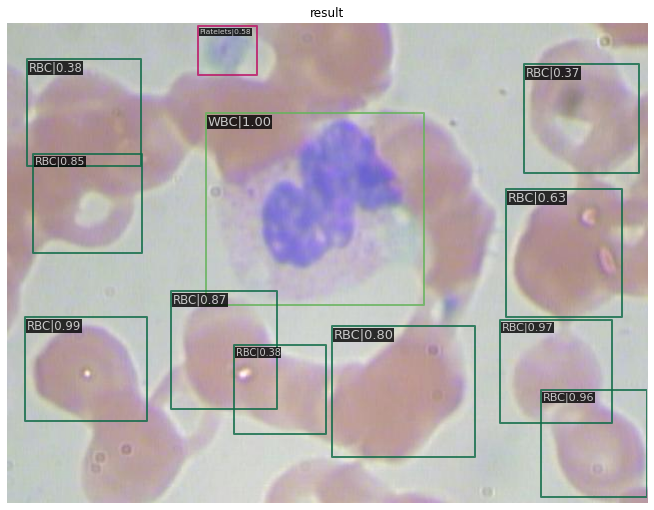

In [32]:
import cv2
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

img = cv2.imread('/content/BCCD_Dataset/BCCD/JPEGImages/BloodImage_00007.jpg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result)

### 테스트 데이터 세트에 Inference 및 Evaluation 적용하기
* 지금까지는 evaluation을 validation set에 대해서만 진행했었음. 이번엔 test 셋에 대해서 진행 예정.
* https://mmdetection.readthedocs.io/en/v2.21.0/3_exist_data_new_model.html 여기 맨 밑에 'Test and inference' 코드 참고
* 런타임 다시 시작 수행 필요(버그?) - 
* tools/test.py 스크립트는 colab에서 오류 발생
* 테스트용 Dataset과 DataLoader생성하고 single_gpu_test()를 호출하여 inference 결과를 반환. batch_size를 1로 설정하지 않으면 single_gpu_test() 오류 발생. 

In [1]:
### 아래는 런타임 다시 시작 후 실행

from mmcv import Config
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset
from mmdet.apis import set_random_seed

@DATASETS.register_module(force=True)
class BCCDDataset(CocoDataset):
  CLASSES = ('WBC', 'RBC', 'Platelets') 

config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth' # 학습 안할거니까 사실 필요없음.

cfg = Config.fromfile(config_file)

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'BCCDDataset'
cfg.data_root = '/content/BCCD_Dataset/BCCD/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'BCCDDataset'
cfg.data.train.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.train.ann_file = 'train.json'
cfg.data.train.img_prefix = 'JPEGImages'

cfg.data.val.type = 'BCCDDataset'
cfg.data.val.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.val.ann_file = 'val.json'
cfg.data.val.img_prefix = 'JPEGImages'

cfg.data.test.type = 'BCCDDataset'
cfg.data.test.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.test.ann_file = 'test.json'
cfg.data.test.img_prefix = 'JPEGImages'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 3
# pretrained 모델
cfg.load_from = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = 'bbox'
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

# !!!!! batch 설정 !!!!
# bug(?)로 인해 test용 dataset evaluation 시 1로 설정. data loader에서 GPU갯수별 Batch size 임. 
# 2을 설정하면 GPU하나당 2을 설정. GPU가 4개면 4x2
cfg.data.samples_per_gpu = 1  # 1이 아니면 오류.

# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device='cuda'
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [2]:
# config파일을 생성한다.! dump : 파일로 만든다.
cfg.dump('/content/tutorial_exps/bccd_faster_rcnn_conf.py')

In [3]:
# 결과 저장할 폴더.
!mkdir -p /content/show_test_output

In [4]:
# tools/test.py 는 colab에서 제대로 동작하지 않음. 
%cd /content/mmdetection
!python tools/test.py /content/tutorial_exps/bccd_faster_rcnn_conf.py /content/tutorial_exps/epoch_12.pth \
--eval 'bbox' \  # coco 기준의 mAP
--show-dir /content/show_test_output

/content/mmdetection
/usr/local/lib/python3.7/dist-packages/mmdet-2.24.1-py3.7.egg/mmdet/utils/setup_env.py:39: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/usr/local/lib/python3.7/dist-packages/mmdet-2.24.1-py3.7.egg/mmdet/utils/setup_env.py:49: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
Traceback (most recent call last):
  File "tools/test.py", line 270, in <module>
    main()
  File "tools/test.py", line 213, in main
    dataset = build_dataset(cfg.data.test)
  File "/usr/local/lib/python3.7/dist-pa

NameError: ignored

## 오류 나게 됨. "BCCDDataset is not in dataset registry'
* 데이터셋이 registry에 등록이 안되어있다는 소리함. 
* colab에서 python 스크립트를 실행시, 다른 프로세스를 만들어서 실행되므로 거기선 BCCDDataset을 인지 못함.
* python console에서는 문제 없음.

### colab 대안: tools/test.py의 코드를 쪼개서 필요한 부분만 강사님이 아래와 같이 제작함.
* 버그가 있긴 함.
* 테스트용 dataset와 dataloader를 별도로 설정하고 trained된 checkpoint 모델을 로딩하여 test 수행. 

In [5]:
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)

# test용 Dataset과 DataLoader 생성. 
# build_dataset()호출 시 list로 감싸지 않는 것이 train용 dataset 생성시와 차이. 
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(    # pytorch의 dataloader와 같음.
        dataset,
        # 반드시 아래 samples_per_gpu 인자값은 1로 설정
        samples_per_gpu=cfg.data.samples_per_gpu,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

# 반드시 아래 코드에서 'img' 키값이 tensor로 출력되어야 함. 
next(iter(data_loader))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{'img': [tensor([[[[0.9474, 0.9474, 0.9474,  ..., 0.0000, 0.0000, 0.0000],
            [0.9474, 0.9474, 0.9474,  ..., 0.0000, 0.0000, 0.0000],
            [0.9646, 0.9646, 0.9646,  ..., 0.0000, 0.0000, 0.0000],
            ...,
            [1.1700, 1.1700, 1.1700,  ..., 0.0000, 0.0000, 0.0000],
            [1.1700, 1.1700, 1.1700,  ..., 0.0000, 0.0000, 0.0000],
            [1.1700, 1.1700, 1.1700,  ..., 0.0000, 0.0000, 0.0000]],
  
           [[1.2031, 1.2031, 1.2031,  ..., 0.0000, 0.0000, 0.0000],
            [1.2031, 1.2031, 1.2031,  ..., 0.0000, 0.0000, 0.0000],
            [1.2206, 1.2206, 1.2206,  ..., 0.0000, 0.0000, 0.0000],
            ...,
            [1.5007, 1.5007, 1.5007,  ..., 0.0000, 0.0000, 0.0000],
            [1.5007, 1.5007, 1.5007,  ..., 0.0000, 0.0000, 0.0000],
            [1.5007, 1.5007, 1.5007,  ..., 0.0000, 0.0000, 0.0000]],
  
           [[1.3851, 1.3851, 1.3851,  ..., 0.0000, 0.0000, 0.0000],
            [1.3851, 1.3851, 1.3851,  ..., 0.0000, 0.0000, 0.0000],

In [6]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# 런타임 다시시작으로 메모리에 있던 모델이 날라갔기 때문에 파일로 부터 가져온다.
checkpoint_file = '/content/tutorial_exps/epoch_12.pth'

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')

load checkpoint from local path: /content/tutorial_exps/epoch_12.pth


In [7]:
from mmdet.apis import multi_gpu_test, single_gpu_test
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# 병렬 처리를 위한 MMDataParallel()
model_ckpt = MMDataParallel(model_ckpt, device_ids=[0])
# single_gpu_test() 를 호출하여 test데이터 세트의 interence 수행. 반드시 batch size는 1이 되어야 함. 
# 위에서 만든 /content/show_test_output 디렉토리에 interence 결과가 시각화된 이미지가 저장됨. 
# True : output 결과를 저장해준다. 0.3 : score threshold.
outputs = single_gpu_test(model_ckpt, data_loader, True, '/content/show_test_output', 0.3)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 72/72, 1.9 task/s, elapsed: 38s, ETA:     0s

### batch 크기를 1보다 키우고 테스트 수행 하려면 (권장하지 않음)
* 만일 batch size를 1보다 크게 해서 설정하려면 cfg.data.samples_per_gpu 값을 1보다 크게 설정하고 single_gpu_test() 함수의 bug(?) 코드를 수정 필요. 
* 다시 런타임 다시 시작을 실행 후 config 부터 재 설정후 아래 코드 수행 필요. 여기서는 수행하지 않는 걸로 스킵

In [8]:
'''
import os.path as osp
import pickle
import shutil
import tempfile
import time

import mmcv
import torch
import torch.distributed as dist
from mmcv.image import tensor2imgs
from mmcv.runner import get_dist_info

def single_gpu_test_batch(model,
                    data_loader,
                    show=False,
                    out_dir=None,
                    show_score_thr=0.3):
    model.eval()
    results = []
    dataset = data_loader.dataset
    prog_bar = mmcv.ProgressBar(len(dataset))
    for i, data in enumerate(data_loader):
        with torch.no_grad():
            result = model(return_loss=False, rescale=True, **data)

        batch_size = len(result)
        if show or out_dir:
            if batch_size == 1 and isinstance(data['img'][0], torch.Tensor):
                img_tensor = data['img'][0]
            else:
                # 아래 코드를 주석 처리 필요. batch_size가 1보다 클때는 data['img'][0].data[0]가 아니라 data['img'][0].data 가 되어야 함. 
                #img_tensor = data['img'][0].data[0]  # 원래코드
                # 아래는 버그(?) 수정 코드 
                img_tensor = data['img'][0].data
                print('img_tensor shape2:', img_tensor.shape)
            img_metas = data['img_metas'][0].data[0]
            imgs = tensor2imgs(img_tensor, **img_metas[0]['img_norm_cfg'])
            assert len(imgs) == len(img_metas)

            for i, (img, img_meta) in enumerate(zip(imgs, img_metas)):
                h, w, _ = img_meta['img_shape']
                img_show = img[:h, :w, :]

                ori_h, ori_w = img_meta['ori_shape'][:-1]
                img_show = mmcv.imresize(img_show, (ori_w, ori_h))

                if out_dir:
                    out_file = osp.join(out_dir, img_meta['ori_filename'])
                else:
                    out_file = None

                model.module.show_result(
                    img_show,
                    result[i],
                    show=show,
                    out_file=out_file,
                    score_thr=show_score_thr)

        # encode mask results
        if isinstance(result[0], tuple):
            result = [(bbox_results, encode_mask_results(mask_results))
                      for bbox_results, mask_results in result]
        results.extend(result)

        for _ in range(batch_size):
            prog_bar.update()
    return results

from mmdet.apis import multi_gpu_test, single_gpu_test
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

model_ckpt = MMDataParallel(model_ckpt, device_ids=[0])
# single_gpu_test() 를 호출하여 test데이터 세트의 interence 수행. 반드시 batch size는 1이 되어야 함. 
outputs = single_gpu_test(model_ckpt, data_loader, True, '/content/tutorial_exps', 0.3)
'''


"\nimport os.path as osp\nimport pickle\nimport shutil\nimport tempfile\nimport time\n\nimport mmcv\nimport torch\nimport torch.distributed as dist\nfrom mmcv.image import tensor2imgs\nfrom mmcv.runner import get_dist_info\n\ndef single_gpu_test_batch(model,\n                    data_loader,\n                    show=False,\n                    out_dir=None,\n                    show_score_thr=0.3):\n    model.eval()\n    results = []\n    dataset = data_loader.dataset\n    prog_bar = mmcv.ProgressBar(len(dataset))\n    for i, data in enumerate(data_loader):\n        with torch.no_grad():\n            result = model(return_loss=False, rescale=True, **data)\n\n        batch_size = len(result)\n        if show or out_dir:\n            if batch_size == 1 and isinstance(data['img'][0], torch.Tensor):\n                img_tensor = data['img'][0]\n            else:\n                # 아래 코드를 주석 처리 필요. batch_size가 1보다 클때는 data['img'][0].data[0]가 아니라 data['img'][0].data 가 되어야 함. \n             

### 반환된 test용 데이터세트의 inference 적용 결과 확인 및 성능 evaluation 수행. 

In [10]:
print('결과 outputs type:', type(outputs))
print('evalution 된 파일의 갯수:', len(outputs))  # 72개 테스트 이미지
print('첫번째 evalutation 결과의 type:', type(outputs[0]))  # list
print('첫번째 evaluation 결과의 CLASS 갯수:', len(outputs[0])) # class 갯수만큼(3개)
print('첫번째 evaluation 결과의 CLASS ID 0의 type과 shape', type(outputs[0][0]), outputs[0][0].shape) # (6, 5) 5는 좌표값, 6은 obj detect된 갯수.

결과 outputs type: <class 'list'>
evalution 된 파일의 갯수: 72
첫번째 evalutation 결과의 type: <class 'list'>
첫번째 evaluation 결과의 CLASS 갯수: 3
첫번째 evaluation 결과의 CLASS ID 0의 type과 shape <class 'numpy.ndarray'> (1, 5)


In [11]:
print(outputs)

[[array([[198.51515  ,  90.75478  , 416.0801   , 282.42865  ,   0.9968265]],
      dtype=float32), array([[1.7429491e+01, 2.9470316e+02, 1.3918443e+02, 3.9868671e+02,
        9.8871684e-01],
       [4.9272006e+02, 2.9780792e+02, 6.0467371e+02, 4.0007068e+02,
        9.6531606e-01],
       [5.3357050e+02, 3.6706195e+02, 6.3939801e+02, 4.7454391e+02,
        9.5682693e-01],
       [1.6326138e+02, 2.6841321e+02, 2.6998367e+02, 3.8637137e+02,
        8.7094837e-01],
       [2.5266464e+01, 1.3155438e+02, 1.3496652e+02, 2.3019063e+02,
        8.5146564e-01],
       [3.2454785e+02, 3.0350797e+02, 4.6762817e+02, 4.3497815e+02,
        8.0126542e-01],
       [4.9862125e+02, 1.6694337e+02, 6.1464514e+02, 2.9466736e+02,
        6.3374400e-01],
       [1.9482458e+01, 3.6036274e+01, 1.3357623e+02, 1.4308456e+02,
        3.8249636e-01],
       [2.2629716e+02, 3.2296347e+02, 3.1804697e+02, 4.1176071e+02,
        3.7552780e-01],
       [5.1626544e+02, 4.1450981e+01, 6.3129095e+02, 1.5020134e+02,
     

In [12]:
metric = dataset.evaluate(outputs, metric='bbox')
print(metric)


Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.62s).
Accumulating evaluation results...
DONE (t=0.06s).

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.635
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.922
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.737
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.612
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.507
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.477
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95